In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons,make_circles,make_blobs
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import pandas as pd
import numpy as np
import time

In [2]:
x1,y1 = make_circles(n_samples=1500, factor=.5, noise=.05)
x2,y2 = make_moons(n_samples=1500,noise=0.09,random_state=0)
x3,y3 = make_blobs(n_samples=1500,cluster_std=[1.0, 2.5, 0.5],random_state=170) #Varied
x4,y4 = np.random.rand(1500, 2), None
x5,y5 = make_blobs(n_samples=1500,random_state=8)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(x5, transformation)
x6,y6 = (X_aniso, y5)

df = pd.read_csv("boxes.csv")
dataset = np.array(df.astype(float).values.tolist())
x7 = StandardScaler().fit_transform(dataset)

In [3]:
class Mean_Shift:
    def __init__(self, radius=1):
        self.radius = radius

    #data : the resultant centroids from the k-means operation
    def fit(self, data):
        
        # centroids : contains the updated centroids
        # set all input dataset points as a centroid for a cluster
        self.centroids = {}
        for i in range(len(data)):
            self.centroids[i] = data[i]
        
        # track : contains the mapping of the resultant kmeans centroids with the updated centroids
        # set every centroid to its self
        track = {}
        for i in self.centroids.values():
            track[tuple(i)] = i
        
        
        while True:
            new_centroids = []
            for i in self.centroids:
                in_bandwidth = []
                centroid = self.centroids[i]
                
                # collect all points from the original data that are
                # within the raduis of the current centroid in "in_bandwidth"
                for featureset in self.centroids.values():
                    if np.linalg.norm(featureset-centroid) < self.radius:
                        in_bandwidth.append(featureset)
                        
                # avergae the in_bandwidth points to get the new centroid and
                # save it in the "new_centroids" list
                new_centroid = np.average(in_bandwidth,axis=0)
                new_centroids.append(tuple(new_centroid))
                
                # update the track dictionary with the new centroids
                for j in track.keys():
                    if track[j][0] == centroid[0] and track[j][1] == centroid[1]:
                        track[j] = np.array(new_centroid)
            
            # save centroids before updates to terminate when no change occur
            prev_centroids = dict(self.centroids)
            
            # remove any coincide centroids in the new generated centroids and 
            # update the centroid list
            uniques = sorted(list(set(new_centroids)))
            self.centroids = {}
            for i in range(len(uniques)):
                self.centroids[i] = np.array(uniques[i])
                
            # terminate when previous centroid list equals the new centroid list
            optimized = True
            for i in self.centroids:
                if not np.array_equal(self.centroids[i], prev_centroids[i]):
                    optimized = False
                if not optimized:
                    break
                
            if optimized:
                break

        return track


In [4]:
class K_Means:
    def __init__(self, k=2, tol=0.001, max_iter=300):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter

    def fit(self,data):

        # centroids : contains the updated centroids
        # set the first k data points as centroids
        self.centroids = {}
        for i in range(self.k):
            self.centroids[i] = data[i]

        for i in range(self.max_iter):
            
            # classifications : carry the mapping of each centroid index and the nearest points to each
            # initialize classifications dictionary with empty lists
            self.classifications = {}
            for i in range(self.k):
                self.classifications[i] = []
                
            # group points to their nearest centroid based on L2 norm
            for featureset in data:
                distances = [np.linalg.norm(featureset-self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.classifications[classification].append(featureset)

            # save centroids before updates to terminate when no change occur
            prev_centroids = dict(self.centroids)

            # update the centroids by averaging each collected group of points 
            for classification in self.classifications:
                self.centroids[classification] = np.average(self.classifications[classification],axis=0)

            # terminate when the change rate is smaller than the tolerance
            # ( the loop also terminates when it reachs the max number of iterations)
            optimized = True

            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                if np.sum((current_centroid-original_centroid)/original_centroid*100.0) > self.tol:
                    optimized = False

            if optimized:
                break
                
        return self.classifications,self.centroids

In [5]:
def Map_points_to_clusters(classifications,centroids):
    final_Centroids = {}
    final_Classifications = {}
    
    for i in centroids:
        final_Centroids[tuple(centroids[i])] = classifications[i] 

    for i in final_Centroids:
        if tuple(track[i]) in final_Classifications:
            final_Classifications[tuple(track[i])] += final_Centroids[i]
        else:
            final_Classifications[tuple(track[i])] = final_Centroids[i]
    
    return final_Classifications

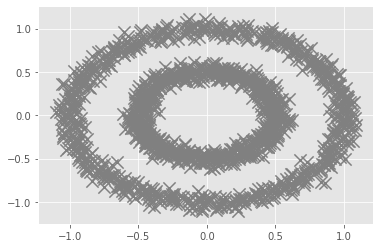

In [6]:
plt.scatter(x1[:,0],x1[:,1], marker="x", color='gray', s=150, linewidths=0.5)
plt.show()
colors = 10*["g","r","c","b","k","m","orange","pink","brown"]

In [7]:
# perform K-means on dataset
tic = time.perf_counter()
kmeans = K_Means(k = 15)
classifications,centroids = kmeans.fit(x1)
toc = time.perf_counter()
print(f"K-means toke {toc - tic:0.4f} seconds")

# perform Mean shift on K-means resultant data
tic = time.perf_counter()
meanShift = Mean_Shift(radius=1)
track = meanShift.fit(list(centroids.values()))
toc = time.perf_counter()
print(f"Mean shift toke {toc - tic:0.4f} seconds")

# map dataset points to resultant Mean shift clusters
tic = time.perf_counter()
clusters = Map_points_to_clusters(classifications,centroids)
toc = time.perf_counter()
print(f"Mapping point toke {toc - tic:0.4f} seconds")

K-means toke 6.1570 seconds
Mean shift toke 0.0113 seconds
Mapping point toke 0.0004 seconds


Starting ploting


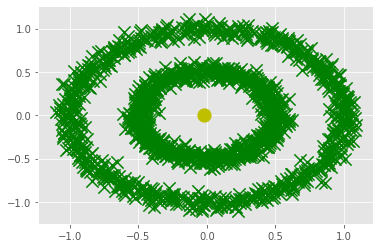

In [8]:
print("Starting ploting")
color_index = 0
for cluster in clusters:
    feature_set = np.array(clusters[cluster])
    color = colors[color_index]
    plt.scatter(feature_set[:,0], feature_set[:,1], marker="x", color=color, s=150, linewidths=0.5)
    plt.scatter(cluster[0], cluster[1],
                marker="o", color="y", s=150, linewidths=2)
    color_index += 1
plt.show()

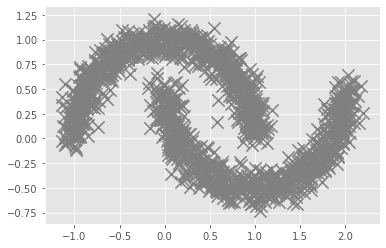

In [9]:
plt.scatter(x2[:,0],x2[:,1], marker="x", color='gray', s=150, linewidths=0.5)
plt.show()
colors = 10*["g","r","c","b","k","m","orange","pink","brown"]

In [10]:
# perform K-means on dataset
tic = time.perf_counter()
kmeans = K_Means(k = 20)
classifications,centroids = kmeans.fit(x2)
toc = time.perf_counter()
print(f"K-means toke {toc - tic:0.4f} seconds")

# perform Mean shift on K-means resultant data
tic = time.perf_counter()
meanShift = Mean_Shift(radius=0.6)
track = meanShift.fit(list(centroids.values()))
toc = time.perf_counter()
print(f"Mean shift toke {toc - tic:0.4f} seconds")

# map dataset points to resultant Mean shift clusters
tic = time.perf_counter()
clusters = Map_points_to_clusters(classifications,centroids)
toc = time.perf_counter()
print(f"Mapping point toke {toc - tic:0.4f} seconds")

K-means toke 14.9709 seconds
Mean shift toke 0.0253 seconds
Mapping point toke 0.0008 seconds


Starting ploting


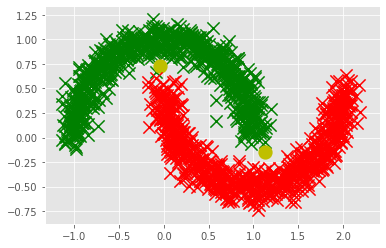

In [11]:
print("Starting ploting")
color_index = 0
for cluster in clusters:
    feature_set = np.array(clusters[cluster])
    color = colors[color_index]
    plt.scatter(feature_set[:,0], feature_set[:,1], marker="x", color=color, s=150, linewidths=0.5)
    plt.scatter(cluster[0], cluster[1],
                marker="o", color="y", s=150, linewidths=2)
    color_index += 1
plt.show()

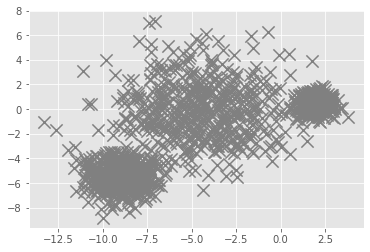

In [12]:
plt.scatter(x3[:,0],x3[:,1], marker="x", color='gray', s=150, linewidths=0.5)
plt.show()
colors = 10*["g","r","c","b","k","m","orange","pink","brown"]

In [13]:
# perform K-means on dataset
tic = time.perf_counter()
kmeans = K_Means(k = 20)
classifications,centroids = kmeans.fit(x3)
toc = time.perf_counter()
print(f"K-means toke {toc - tic:0.4f} seconds")

# perform Mean shift on K-means resultant data
tic = time.perf_counter()
meanShift = Mean_Shift(radius=3.5)
track = meanShift.fit(list(centroids.values()))
toc = time.perf_counter()
print(f"Mean shift toke {toc - tic:0.4f} seconds")

# map dataset points to resultant Mean shift clusters
tic = time.perf_counter()
clusters = Map_points_to_clusters(classifications,centroids)
toc = time.perf_counter()
print(f"Mapping point toke {toc - tic:0.4f} seconds")

K-means toke 17.6154 seconds
Mean shift toke 0.0122 seconds
Mapping point toke 0.0008 seconds


Starting ploting


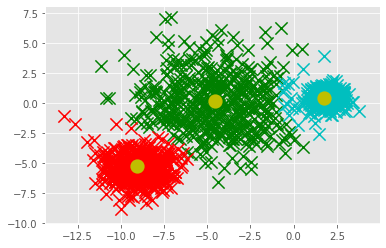

In [14]:
print("Starting ploting")
color_index = 0
for cluster in clusters:
    feature_set = np.array(clusters[cluster])
    color = colors[color_index]
    plt.scatter(feature_set[:,0], feature_set[:,1], marker="x", color=color, s=150, linewidths=0.5)
    plt.scatter(cluster[0], cluster[1],
                marker="o", color="y", s=150, linewidths=2)
    color_index += 1
plt.show()

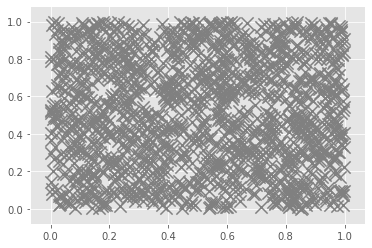

In [15]:
plt.scatter(x4[:,0],x4[:,1], marker="x", color='gray', s=150, linewidths=0.5)
plt.show()
colors = 10*["g","r","c","b","k","m","orange","pink","brown"]

In [16]:
# perform K-means on dataset
tic = time.perf_counter()
kmeans = K_Means(k = 15)
classifications,centroids = kmeans.fit(x4)
toc = time.perf_counter()
print(f"K-means toke {toc - tic:0.4f} seconds")

# perform Mean shift on K-means resultant data
tic = time.perf_counter()
meanShift = Mean_Shift(radius=1)
track = meanShift.fit(list(centroids.values()))
toc = time.perf_counter()
print(f"Mean shift toke {toc - tic:0.4f} seconds")

# map dataset points to resultant Mean shift clusters
tic = time.perf_counter()
clusters = Map_points_to_clusters(classifications,centroids)
toc = time.perf_counter()
print(f"Mapping point toke {toc - tic:0.4f} seconds")

K-means toke 7.5872 seconds
Mean shift toke 0.0055 seconds
Mapping point toke 0.0007 seconds


Starting ploting


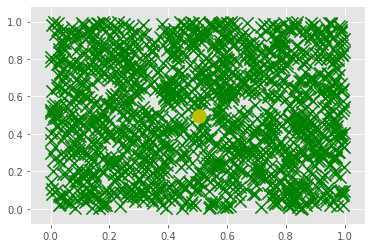

In [17]:
print("Starting ploting")
color_index = 0
for cluster in clusters:
    feature_set = np.array(clusters[cluster])
    color = colors[color_index]
    plt.scatter(feature_set[:,0], feature_set[:,1], marker="x", color=color, s=150, linewidths=0.5)
    plt.scatter(cluster[0], cluster[1],
                marker="o", color="y", s=150, linewidths=2)
    color_index += 1
plt.show()

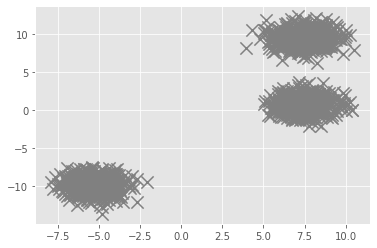

In [18]:
plt.scatter(x5[:,0],x5[:,1], marker="x", color='gray', s=150, linewidths=0.5)
plt.show()
colors = 10*["g","r","c","b","k","m","orange","pink","brown"]

In [19]:
# perform K-means on dataset
tic = time.perf_counter()
kmeans = K_Means(k = 20)
classifications,centroids = kmeans.fit(x5)
toc = time.perf_counter()
print(f"K-means toke {toc - tic:0.4f} seconds")

# perform Mean shift on K-means resultant data
tic = time.perf_counter()
meanShift = Mean_Shift(radius=2)
track = meanShift.fit(list(centroids.values()))
toc = time.perf_counter()
print(f"Mean shift toke {toc - tic:0.4f} seconds")

# map dataset points to resultant Mean shift clusters
tic = time.perf_counter()
clusters = Map_points_to_clusters(classifications,centroids)
toc = time.perf_counter()
print(f"Mapping point toke {toc - tic:0.4f} seconds")

K-means toke 6.5756 seconds
Mean shift toke 0.0235 seconds
Mapping point toke 0.0008 seconds


Starting ploting


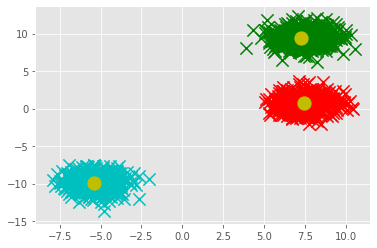

In [20]:
print("Starting ploting")
color_index = 0
for cluster in clusters:
    feature_set = np.array(clusters[cluster])
    color = colors[color_index]
    plt.scatter(feature_set[:,0], feature_set[:,1], marker="x", color=color, s=150, linewidths=0.5)
    plt.scatter(cluster[0], cluster[1],
                marker="o", color="y", s=150, linewidths=2)
    color_index += 1
plt.show()

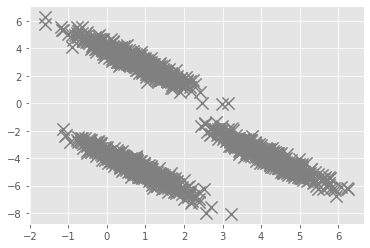

In [21]:
plt.scatter(x6[:,0],x6[:,1], marker="x", color='gray', s=150, linewidths=0.5)
plt.show()
colors = 10*["g","r","c","b","k","m","orange","pink","brown"]

In [22]:
# perform K-means on dataset
tic = time.perf_counter()
kmeans = K_Means(k = 20)
classifications,centroids = kmeans.fit(x6)
toc = time.perf_counter()
print(f"K-means toke {toc - tic:0.4f} seconds")

# perform Mean shift on K-means resultant data
tic = time.perf_counter()
meanShift = Mean_Shift(radius=2)
track = meanShift.fit(list(centroids.values()))
toc = time.perf_counter()
print(f"Mean shift toke {toc - tic:0.4f} seconds")

# map dataset points to resultant Mean shift clusters
tic = time.perf_counter()
clusters = Map_points_to_clusters(classifications,centroids)
toc = time.perf_counter()
print(f"Mapping point toke {toc - tic:0.4f} seconds")

K-means toke 9.4963 seconds
Mean shift toke 0.0192 seconds
Mapping point toke 0.0008 seconds


Starting ploting


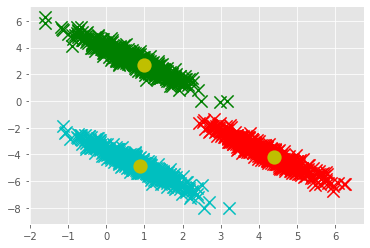

In [23]:
print("Starting ploting")
color_index = 0
for cluster in clusters:
    feature_set = np.array(clusters[cluster])
    color = colors[color_index]
    plt.scatter(feature_set[:,0], feature_set[:,1], marker="x", color=color, s=150, linewidths=0.5)
    plt.scatter(cluster[0], cluster[1],
                marker="o", color="y", s=150, linewidths=2)
    color_index += 1
plt.show()

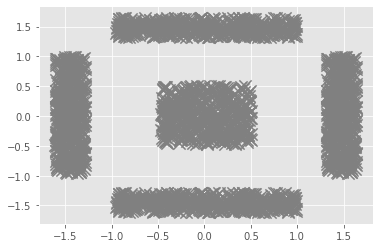

In [24]:
plt.scatter(x7[:,0],x7[:,1], marker="x", color='gray', s=150, linewidths=0.5)
plt.show()
colors = 10*["g","r","c","b","k","m","orange","pink","brown"]

In [25]:
# perform K-means on dataset
tic = time.perf_counter()
kmeans = K_Means(k = 15)
classifications,centroids = kmeans.fit(x7)
toc = time.perf_counter()
print(f"K-means toke {toc - tic:0.4f} seconds")

# perform Mean shift on K-means resultant data
tic = time.perf_counter()
meanShift = Mean_Shift(radius=1)
track = meanShift.fit(list(centroids.values()))
toc = time.perf_counter()
print(f"Mean shift toke {toc - tic:0.4f} seconds")

# map dataset points to resultant Mean shift clusters
tic = time.perf_counter()
clusters = Map_points_to_clusters(classifications,centroids)
toc = time.perf_counter()
print(f"Mapping point toke {toc - tic:0.4f} seconds")

K-means toke 14.6553 seconds
Mean shift toke 0.0079 seconds
Mapping point toke 0.0010 seconds


Starting ploting


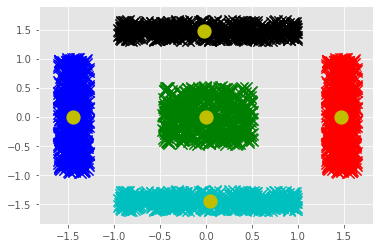

In [26]:
print("Starting ploting")
color_index = 0
for cluster in clusters:
    feature_set = np.array(clusters[cluster])
    color = colors[color_index]
    plt.scatter(feature_set[:,0], feature_set[:,1], marker="x", color=color, s=150, linewidths=0.5)
    plt.scatter(cluster[0], cluster[1],
                marker="o", color="y", s=150, linewidths=2)
    color_index += 1
plt.show()